# pretrained Nbeats model using all seasonality data - 전력소비량
---

     m4데이터의 모든 계절성분 데이터를 기학습모델에 학습시켜 전이학습을 통해 target data를 예측하는 nbeats-lstm 모델이다. 비교 모델로 target데이터를 적합할 단순 lstm과 nbeat 모델이 있으며,각 3개의 모델은 50번의 반복 시행과 예측으로 mse의 분포 히스토그램을 파악하여 pretrained model이 다른 모델에 비해 성능적 우위가 있는지를 파악하려고 한다.
   

In [2]:
# pretrain에 이용할 도메인 데이터 전처리는 사전 모듈에 저장
from m4databasis import base_domain,zt_in,zt_out,M4Meta,inputsize,train_12,train_12_y # 도메인 데이터
from target_data_electronic import * # 타겟데이터
#from korea_solor import test_solor_X,test_solor_y,train_solor_X,train_solor_y

- pretrained data와 target data의 사전 처리는 모듈화하여 import시킴

In [3]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

---
# data shape

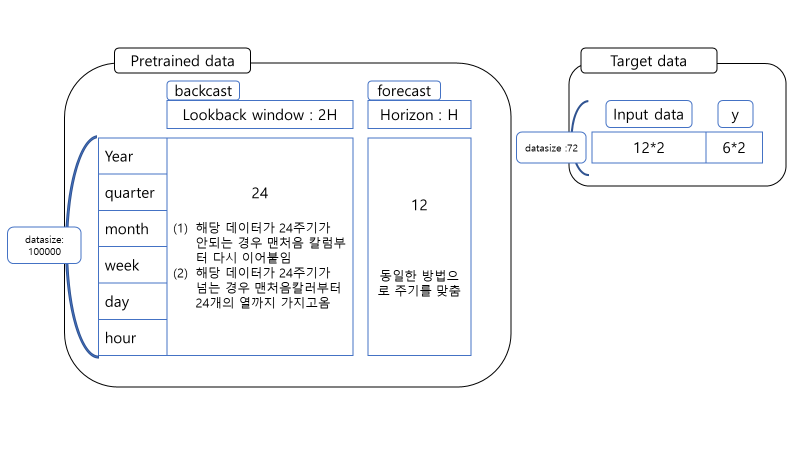

- data scale은 minmax 방식을 채택
- pretrained data는 backcast와 forecast의 분포가 같다고 가정하여 scale을 진행
- target data는 pretrained data와 분포가 다를 것으로 가정하고 별도로 scale을 진행

---
# pretrained model

- m4데이터 모든 계절성분 데이터를 적합
- 각 계절성분마다 각각 horizon과 inputsize가 다르다
- 다른 계절성 데이터 적합시 input과 output 차원이 바뀌어 적합

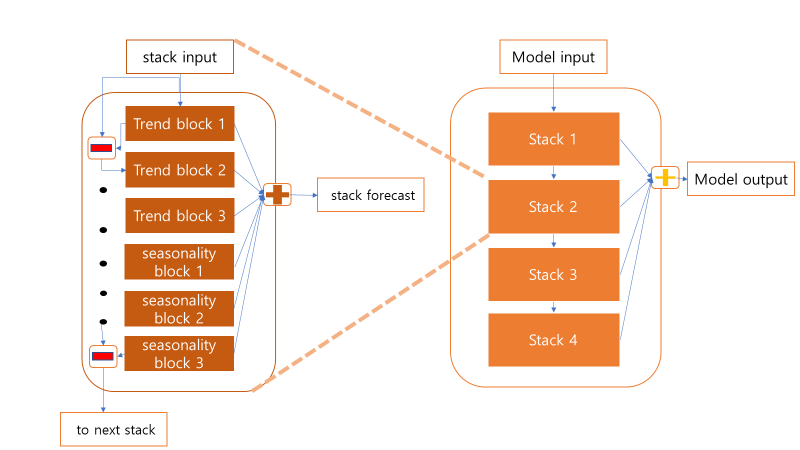

In [12]:
train_12.shape,train_12_y.shape,target_ele_X_test.shape,target_ele_y_test.shape

((100000, 24), (100000, 12), (1, 24), (1, 12))

In [16]:
K.clear_session()

input_dim, output_dim =  1, 1
backcast_, forecast_ = 24,12

model= NBeatsKeras( backcast_length=backcast_, forecast_length=forecast_, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer )
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
#checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
#model.save('best_model.h9')
history = model.fit(train_12,train_12_y,validation_data=(target_ele_X_test,target_ele_y_test),
                    epochs=100, batch_size=128,
                    callbacks=[early_stop])


Epoch 1/100
782/782 [==============================] - 24s 25ms/step - loss: 0.0033 - val_loss: 0.2930
Epoch 2/100
782/782 [==============================] - 15s 19ms/step - loss: 1.3680e-05 - val_loss: 0.2749
Epoch 3/100
782/782 [==============================] - 16s 20ms/step - loss: 1.2210e-05 - val_loss: 0.2435
Epoch 4/100
782/782 [==============================] - 15s 19ms/step - loss: 1.1364e-05 - val_loss: 0.1958
Epoch 5/100
782/782 [==============================] - 15s 19ms/step - loss: 1.1945e-05 - val_loss: 0.1556
Epoch 6/100
782/782 [==============================] - 15s 20ms/step - loss: 1.1282e-05 - val_loss: 0.1405
Epoch 7/100
782/782 [==============================] - 15s 20ms/step - loss: 1.1081e-05 - val_loss: 0.1263
Epoch 8/100
782/782 [==============================] - 15s 19ms/step - loss: 1.0229e-05 - val_loss: 0.1384
Epoch 9/100
782/782 [==============================] - 15s 19ms/step - loss: 1.0622e-05 - val_loss: 0.1274
Epoch 10/100
782/782 [===================

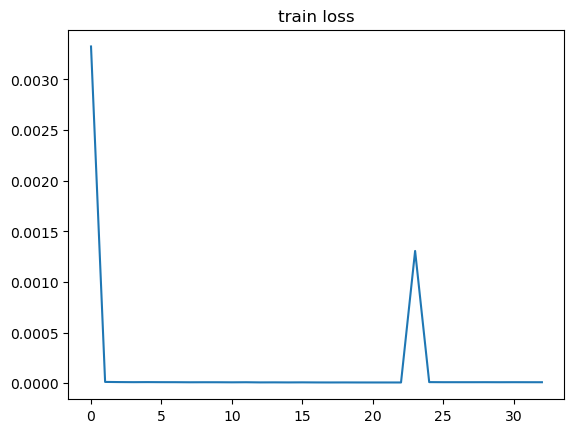

In [19]:
#history_nbeats = np.array([history_lst[i].history['loss'] for i in range(len(history_lst))]).flatten()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('train loss')
plt.show()

---
# pretrained nbeats-lstm

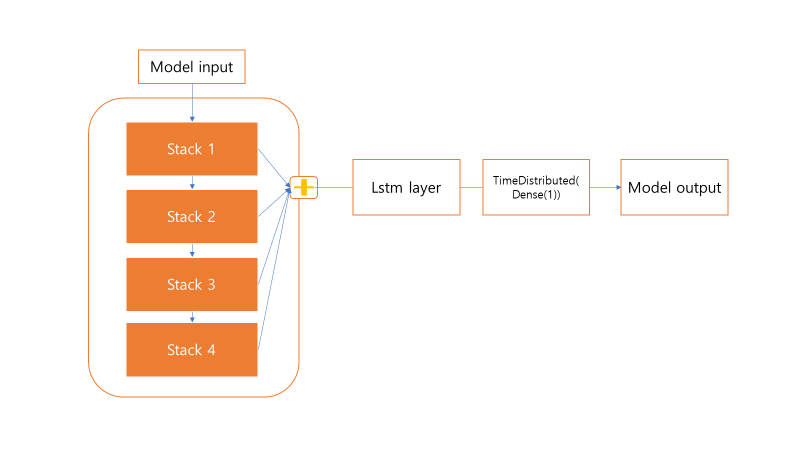

---
# 사전학습모델 반복 fitting

In [71]:
from keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, TimeDistributed

In [22]:
backcast_length = 24
theta_dim1, theta_dim2 = 64,6
forecast_length = 12
unit=128

In [23]:
nbeat_lst=[]
nbeat_time = []
from sklearn.metrics import mean_squared_error
for  i in range(50):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = LSTM(128,return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
    dense_output = TimeDistributed(Dense(1))(lstm_output )

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(target_ele_X_train,target_ele_y_train,validation_data=[target_ele_X_test,target_ele_y_test],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model_combined.predict(target_ele_X_test)
    nbeat_mse=np.mean([mean_squared_error(target_ele_y_test.flatten(),nbeat_pred.flatten()) for i in range(len(target_ele_y_test))])
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

1/1 [==============================] - 2s 2s/step


---
# non pretrained nbeats model
- pretrianed model의 하이퍼파라미터와 동일하게 진행

In [139]:
nbeat_time2

[30.902727603912354, 31.554784774780273, 31.136783361434937]

In [30]:
nbeat_lst2=[]
nbeat_time2 = []
for i in range(50):
    K.clear_session()
    nonbeats= NBeatsKeras( backcast_length=24, forecast_length=12, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nonbeats.compile(loss='mse', optimizer=optimizer )
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
    nonbeat_time1 = time.time()
    history3 = nonbeats.fit(target_ele_X_train,target_ele_y_train,validation_data=[target_ele_X_test,target_ele_y_test],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nonbeat_time2 = time.time()
    no_total_training_time =nonbeat_time2- nonbeat_time1
    nbeat_pred2 = nonbeats.predict(target_ele_X_test)
    nbeat_mse2=np.mean([mean_squared_error(target_ele_y_test[i].flatten(),nbeat_pred2[i].flatten()) for i in range(len(target_ele_y_test))])
    nbeat_lst2.append(nbeat_mse2)
    nbeat_time2.append(no_total_training_time)

1/1 [==============================] - 1s 1s/step
Epoch 29: early stopping
1/1 [==============================] - 1s 1s/step
Epoch 25: early stopping
1/1 [==============================] - 1s 1s/step
Epoch 28: early stopping
1/1 [==============================] - 1s 1s/step
Epoch 29: early stopping
1/1 [==============================] - 1s 1s/step
Epoch 26: early stopping
1/1 [==============================] - 1s 1s/step
Epoch 28: early stopping
1/1 [==============================] - 1s 1s/step


---
# lstm 반복 적합

In [68]:
target_ele_X_train_reshaped = np.expand_dims(target_ele_X_train, axis=-1)
target_ele_X_test_reshaped = np.expand_dims(target_ele_X_test, axis=-1)

In [96]:
target_ele_X_train.shape,target_ele_X_test.shape,target_ele_y_train.shape,target_ele_y_test.shape

((72, 24), (1, 24), (72, 12), (1, 12))

In [109]:
lstm_lst=[]
lstm_time = []
for i in range(50):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(24,1),name='lstmd'))# (timestep, feature)
    modelnon0.add(Dense(12))# output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(target_ele_X_train,target_ele_y_train,validation_data=[target_ele_X_test,target_ele_y_test], epochs=30,
          batch_size=2, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    
    lstm_pred = modelnon0.predict(target_ele_X_test)
    lstm_mse=np.mean([mean_squared_error(target_ele_y_test.flatten(),lstm_pred.flatten()) for i in range(len(target_ele_y_test))])
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

1/1 [==============================] - 0s 271ms/step


---

# test data MSE 히스토그램

- 테스트셋을 50번 반복적합하여 MSE를 측정
- 반복적합시 모델 초기화

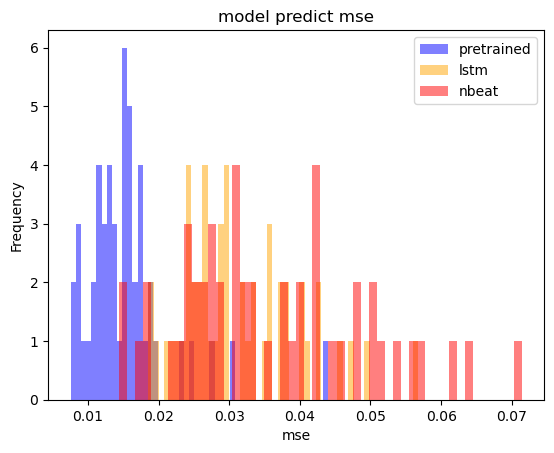

In [110]:
bins = 50

plt.hist(nbeat_lst, bins=bins, alpha=0.5, label='pretrained', color='blue')
plt.hist(lstm_lst, bins=bins, alpha=0.5, label='lstm', color='orange')
plt.hist(nbeat_lst2, bins=bins, alpha=0.5, label='nbeat', color='red')
plt.xlabel('mse')
plt.ylabel('Frequency')
plt.title('model predict mse')
plt.legend()
plt.show()

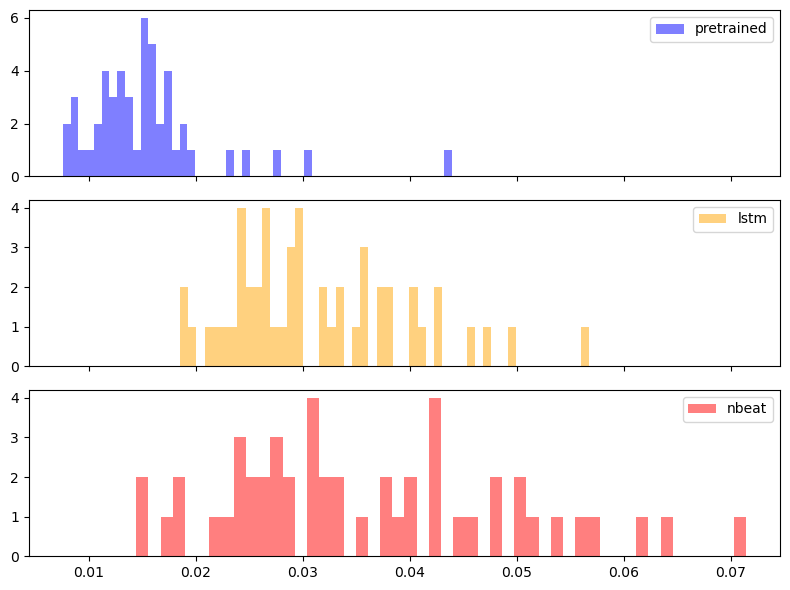

In [111]:

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)


axes[0].hist(nbeat_lst, bins=bins, alpha=0.5, label='pretrained', color='blue')
axes[1].hist(lstm_lst, bins=bins, alpha=0.5, label='lstm', color='orange')
axes[2].hist(nbeat_lst2, bins=bins, alpha=0.5, label='nbeat', color='red')

axes[0].legend()
axes[1].legend()
axes[2].legend()


plt.tight_layout()
plt.show()


In [112]:
np.mean(nbeat_lst),np.mean(lstm_lst),np.mean(nbeat_lst2)

(0.01547656576656258, 0.03146414758830082, 0.03596113438932696)

---

# 모델 적합 시간

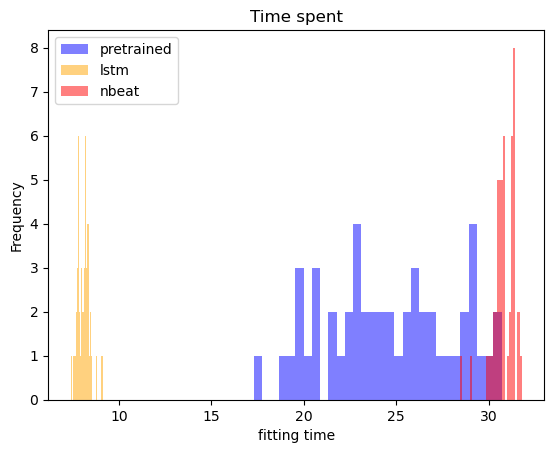

In [145]:
bins = 30

plt.hist(nbeat_time, bins=bins, alpha=0.5, label='pretrained', color='blue')
plt.hist(lstm_time, bins=bins, alpha=0.5, label='lstm', color='orange')
plt.hist(nbeat_time2, bins=bins, alpha=0.5, label='nbeat', color='red')
plt.xlabel('fitting time')
plt.ylabel('Frequency')
plt.title('Time spent')
plt.legend()
plt.show()

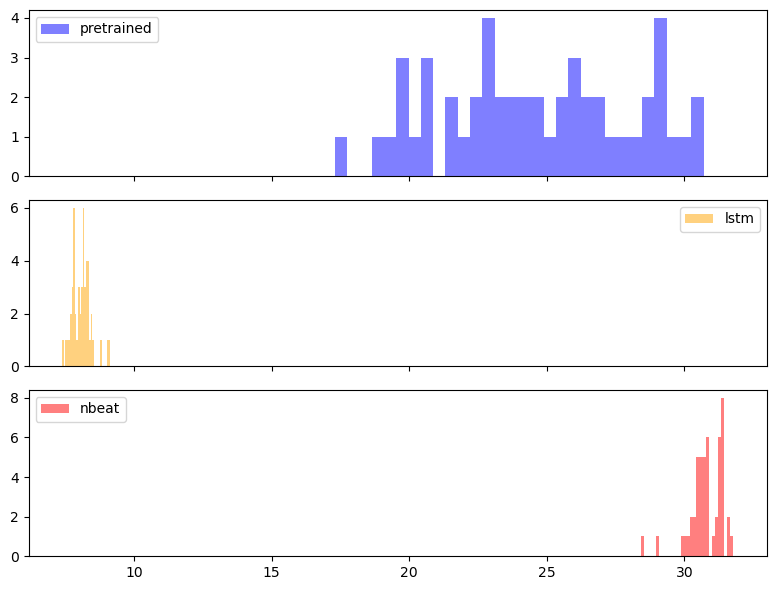

In [149]:

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)


axes[0].hist(nbeat_time, bins=bins, alpha=0.5, label='pretrained', color='blue')
axes[1].hist(lstm_time, bins=bins, alpha=0.5, label='lstm', color='orange')
axes[2].hist(nbeat_time2, bins=bins, alpha=0.5, label='nbeat', color='red')

axes[0].legend()
axes[1].legend()
axes[2].legend()


plt.tight_layout()
plt.show()
